In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import datetime
# from fbprophet import Prophet

In [2]:
dfevents = pd.read_csv('../../data/ecommerce/events.csv')
dfevents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


In [3]:
def unix_time_convert(df):
    times=[]  # convert from unix time format
    for i in df['timestamp']:
        times.append(datetime.datetime.fromtimestamp(i//1000.0))
    df['timestamp']=times
    return df

In [4]:
dfevents = unix_time_convert(dfevents)
dfevents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype         
---  ------         -----         
 0   timestamp      datetime64[ns]
 1   visitorid      int64         
 2   event          object        
 3   itemid         int64         
 4   transactionid  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 105.1+ MB


In [5]:
dfevents.sort_values('timestamp').head()

,timestamp,visitorid,event,itemid,transactionid
1462974,2015-05-02 21:00:04,693516,addtocart,297662,NaN
1464806,2015-05-02 21:00:11,829044,view,60987,NaN
1463000,2015-05-02 21:00:13,652699,view,252860,NaN
1465287,2015-05-02 21:00:24,1125936,view,33661,NaN
1462955,2015-05-02 21:00:26,693516,view,297662,NaN


In [6]:
dfpurch = dfevents.loc[dfevents['event'] == 'transaction', ['timestamp', 'visitorid', 
                                                           'itemid', 'event']]
dfpurch = dfpurch.sort_values('timestamp')
dfpurch.shape

(22457, 4)

In [7]:
# dfpurch.sort_values('timestamp').head()
dfpurch.rename(columns={'timestamp':'ds'}, inplace=True)
dfpurch.head(2)

,ds,visitorid,itemid,event
1465072,2015-05-02 21:27:21,869008,40685,transaction
1463096,2015-05-02 21:35:01,345781,438400,transaction


In [8]:
# df.resample wants the index to be timestamp (BUT)
# For DataFrame objects, the keyword on can be used to specify the column instead 
# of the index for resampling.
dfpurch.resample('D', on="ds").count().tail(3)

,ds,visitorid,itemid,event
ds,,,,
2015-09-15,145,145,145,145
2015-09-16,111,111,111,111
2015-09-17,48,48,48,48


In [9]:
dfday = dfpurch.resample('D', on="ds").count()
dfday = dfday[['event']]
dfday.reset_index(inplace=True)
dfday.rename(columns={'event':'y'}, inplace=True)
print(dfday.shape)
dfday = dfday.iloc[1:-1]  # remove partial days
print(dfday.shape)
dfday.tail(3)

(139, 2)
(137, 2)


,ds,y
135,2015-09-14,173
136,2015-09-15,145
137,2015-09-16,111


In [104]:
# dfday.describe()
dfday.describe().loc['mean']

y    163.474453
Name: mean, dtype: float64

In [ ]:
# matplotlib.style.available
# dfday.to_pickle('../../data/time_ecom/dfday.pkl')

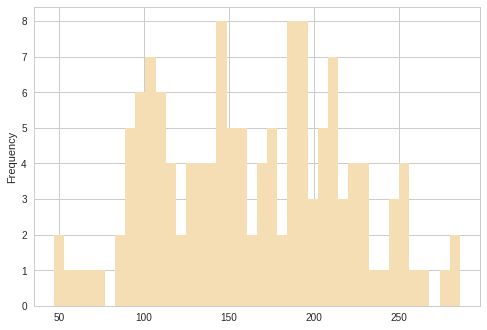

In [48]:
dfday['y'].plot(kind='hist', bins=40, color='wheat')
# dfday['y'].plot(kind='kde', color='wheat')

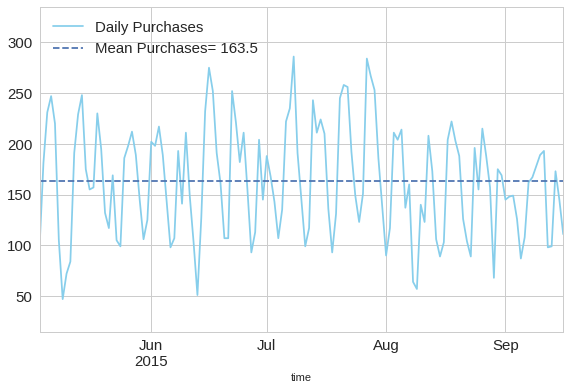

In [100]:
# plt.style.use('seaborn-white')
# plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 
dfdayplot = dfday.rename(columns={'y': 'Daily Purchases', 
                                  'ds': 'time'}).set_index('time')
fig, ax = plt.subplots(figsize=(8,5.5))
dfdayplot.plot(ax=ax, legend=True, color='skyblue') # or 'tan'
# ax.set_label('Daily Purchases')
ax.axhline(163.47, label='Mean Purchases= 163.5', linestyle='--')
# 'Daily Purchases'
# 'Mean Purchases'
# ax.annotate('163.5 Mean Daily Purchases', xy=(0.6, 0.5),  xycoords='axes fraction',
#             xytext=(0.53, 0.17), textcoords='axes fraction', fontsize=14, 
#             arrowprops=dict(facecolor='black', shrink=0.05, width=2),
#             horizontalalignment='right', verticalalignment='top',
#             )
ax.set_ylim(15, 335)
plt.legend(fontsize=15, loc='best') # 'upper right'
# plt.ylabel('Daily Purchase')
plt.tight_layout(pad=1)
# plt.savefig('../img/dfday_daily.png', dpi=100)